Install dependencies

In [1]:
pip install pandas matplotlib seaborn

Detect "unexpected" results and create charts

                     date leagueName           homeTeamName         awayTeamName  homeGoals  \
5437  2014-08-08 19:30:00    Ligue 1                  Reims  Paris Saint Germain          2   
5438  2014-08-09 20:00:00    Ligue 1              SC Bastia            Marseille          3   
5439  2014-08-09 20:00:00    Ligue 1  Evian Thonon Gaillard                 Caen          0   
5441  2014-08-09 20:00:00    Ligue 1                  Lille                 Metz          0   
5442  2014-08-09 20:00:00    Ligue 1            Montpellier             Bordeaux          0   

      awayGoals ActualOutcome ExpectedOutcome  
5437          2             D               A  
5438          3             D               A  
5439          3             A               H  
5441          0             D               H  
5442          1             A               H  


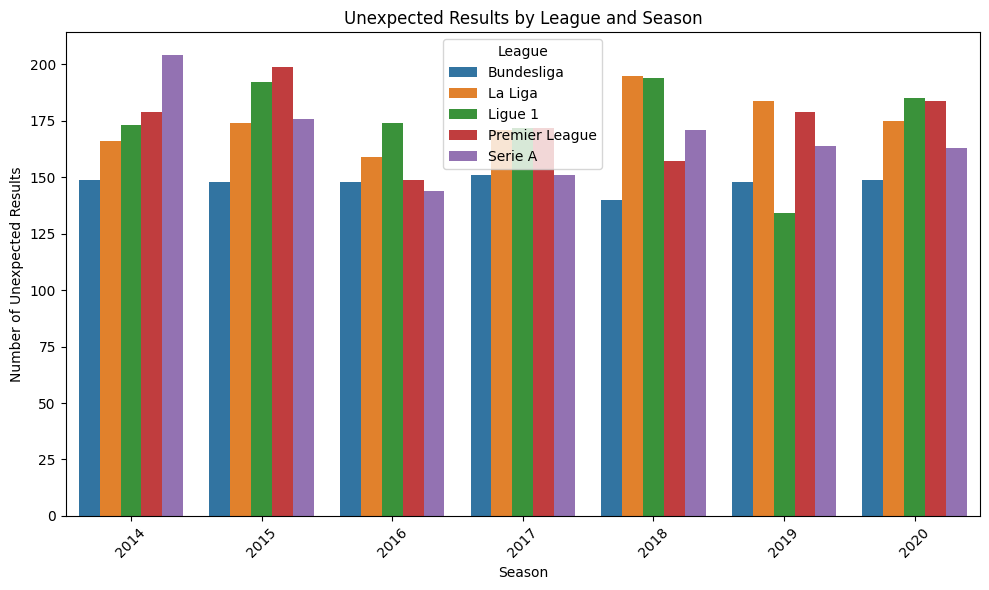

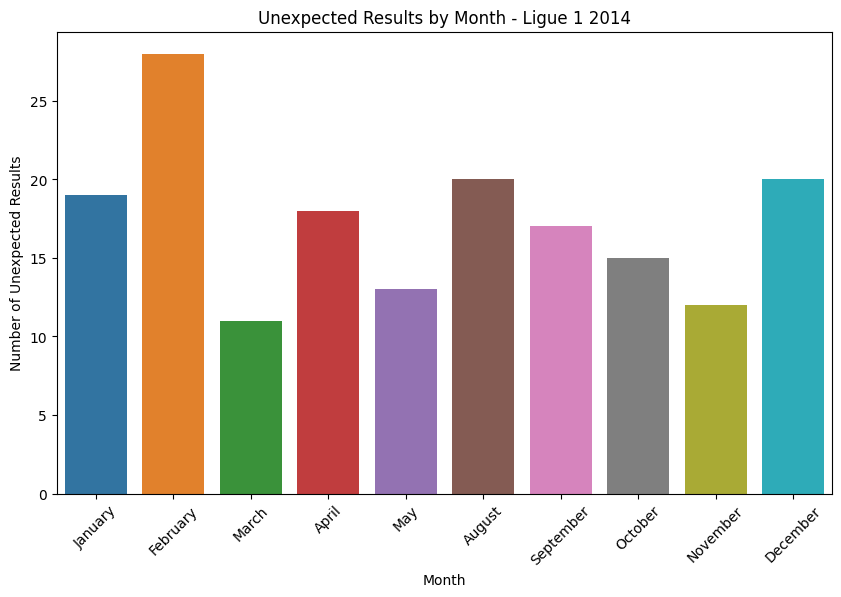

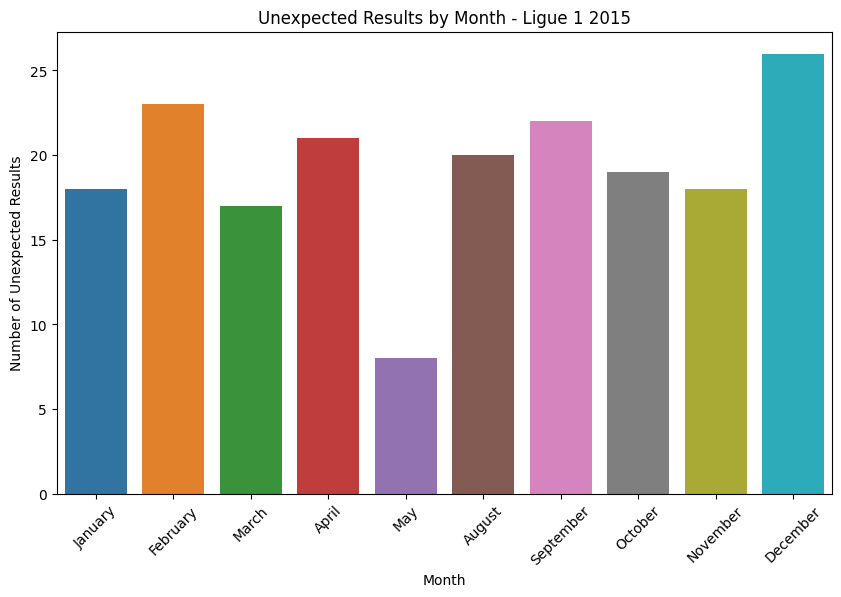

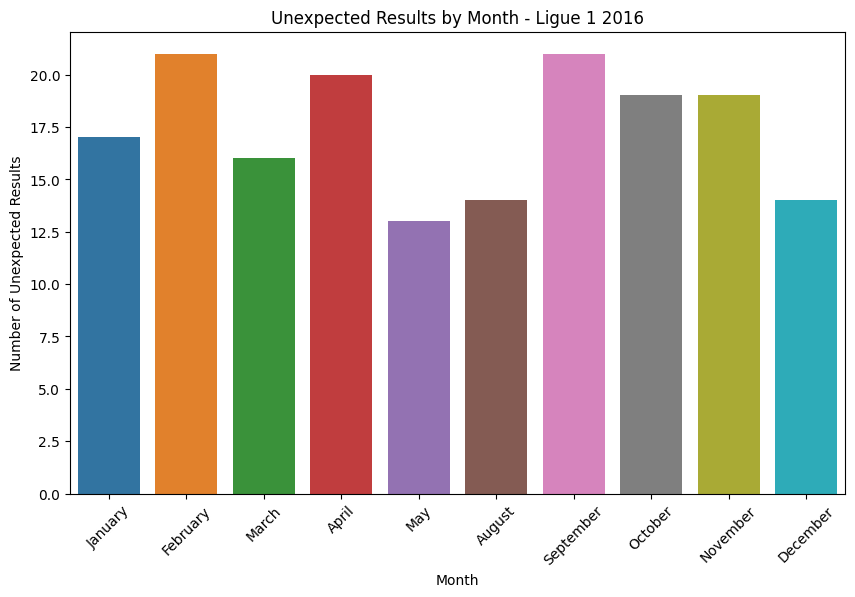

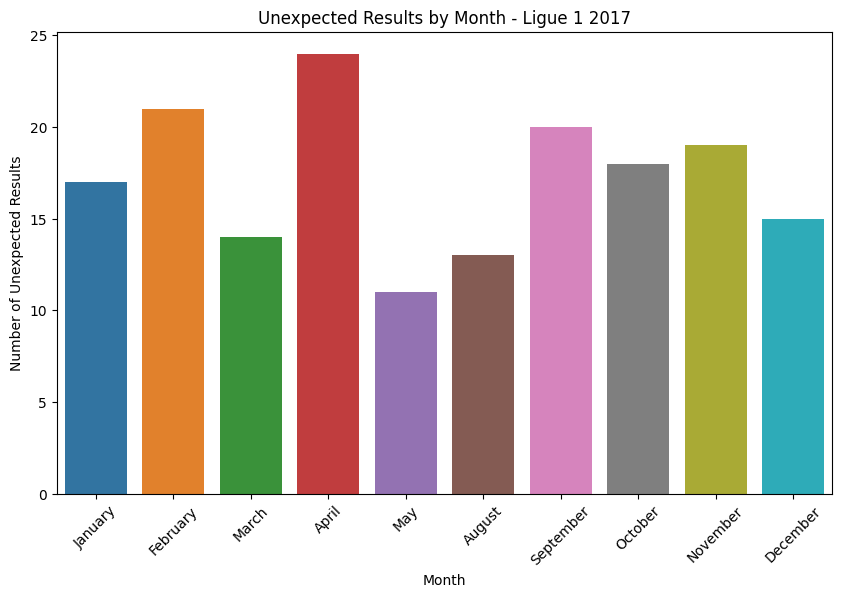

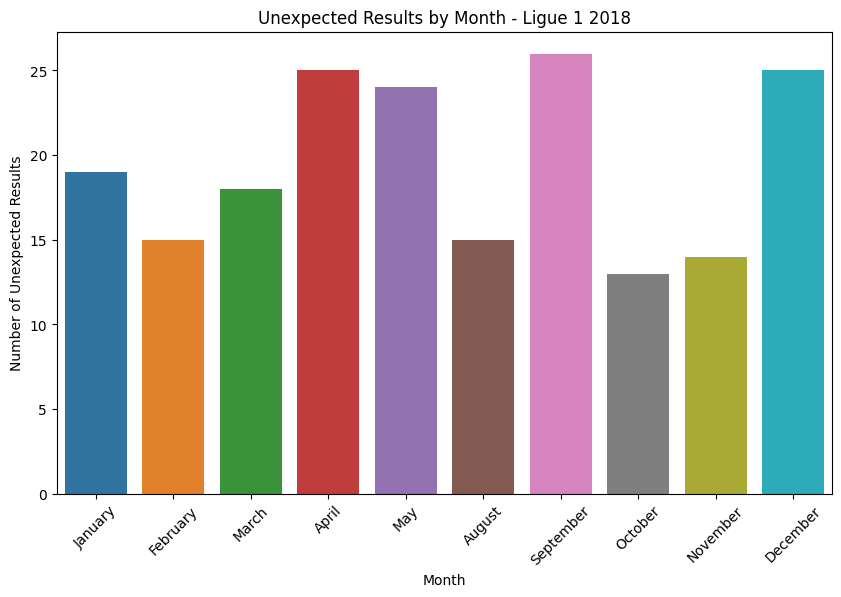

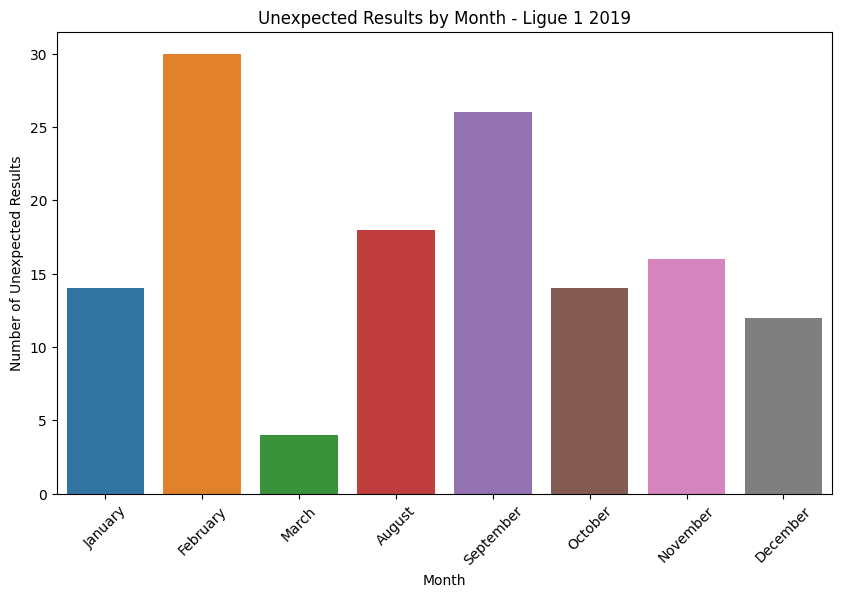

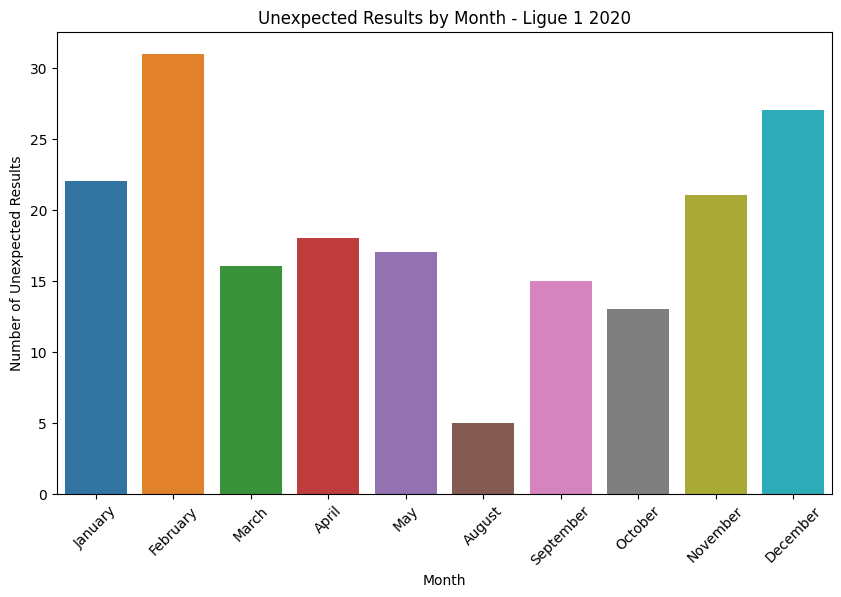

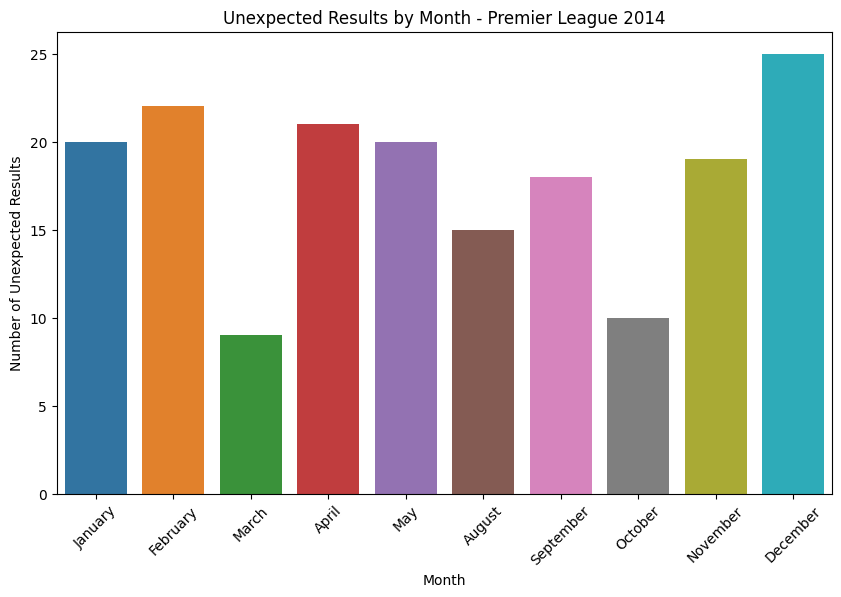

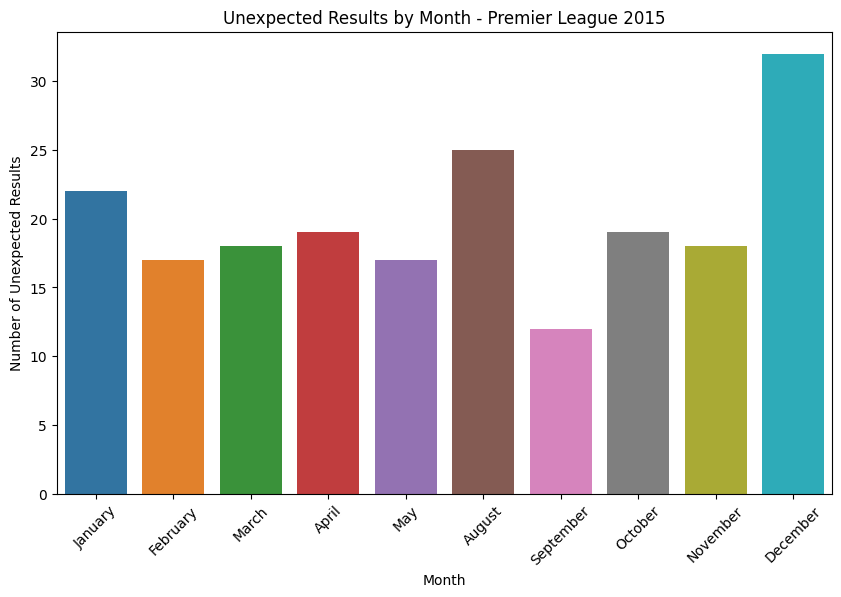

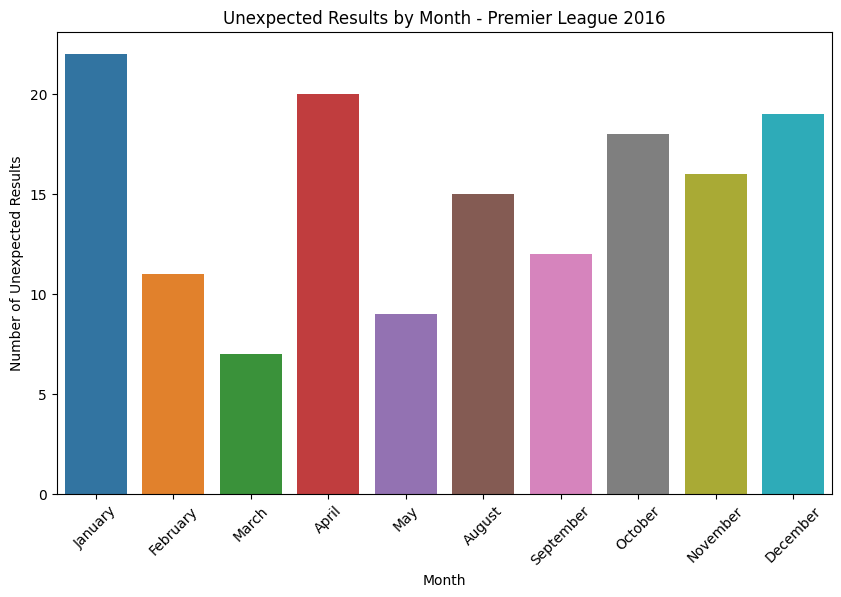

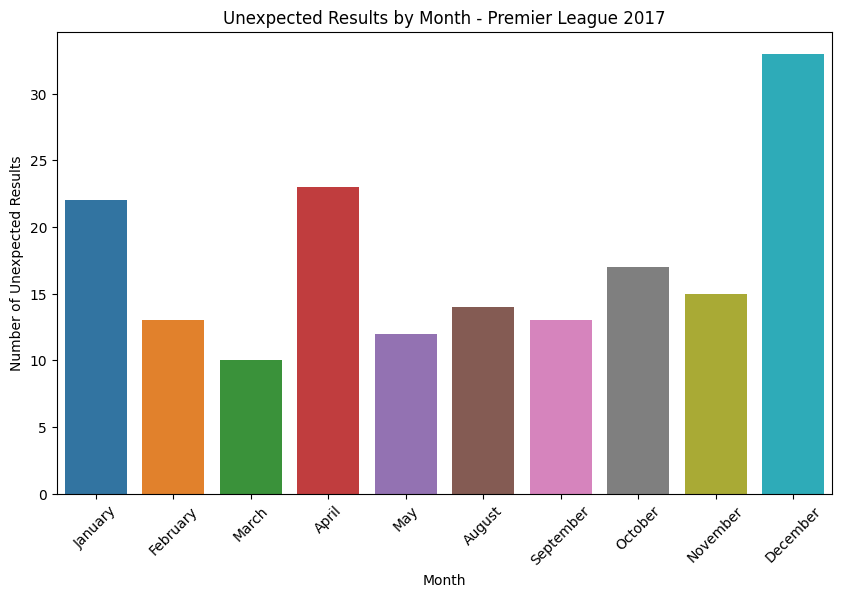

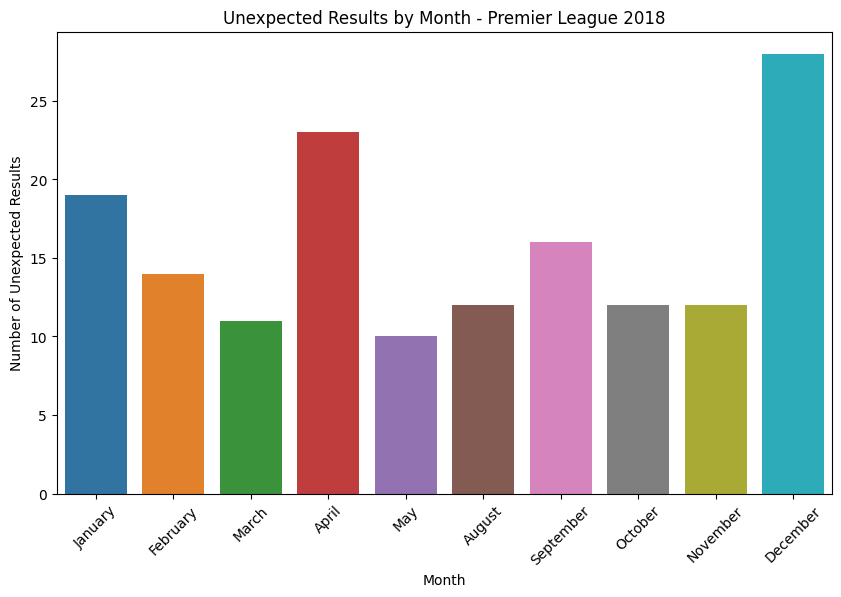

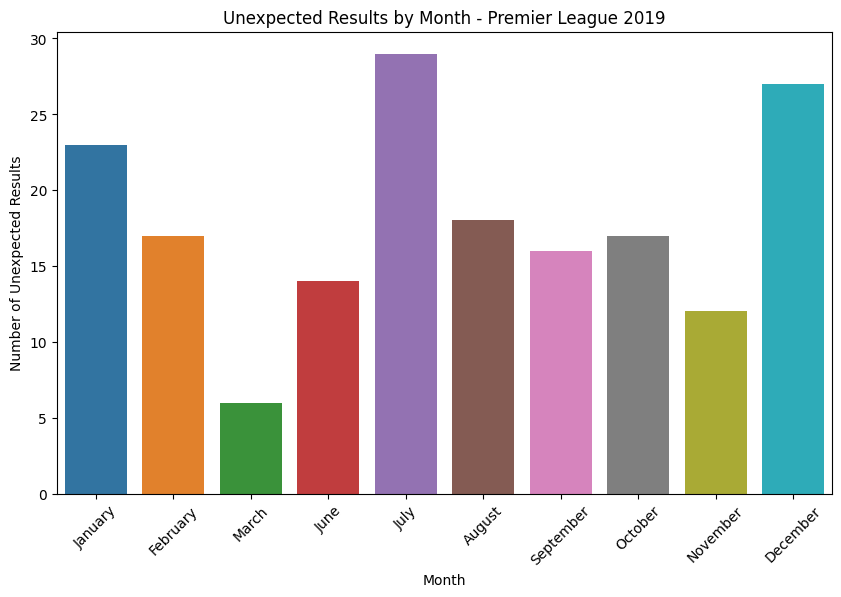

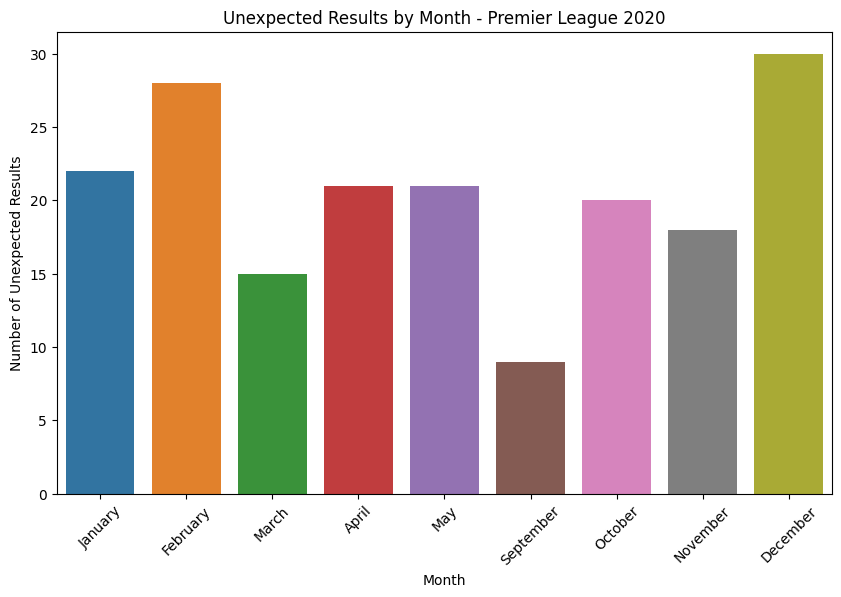

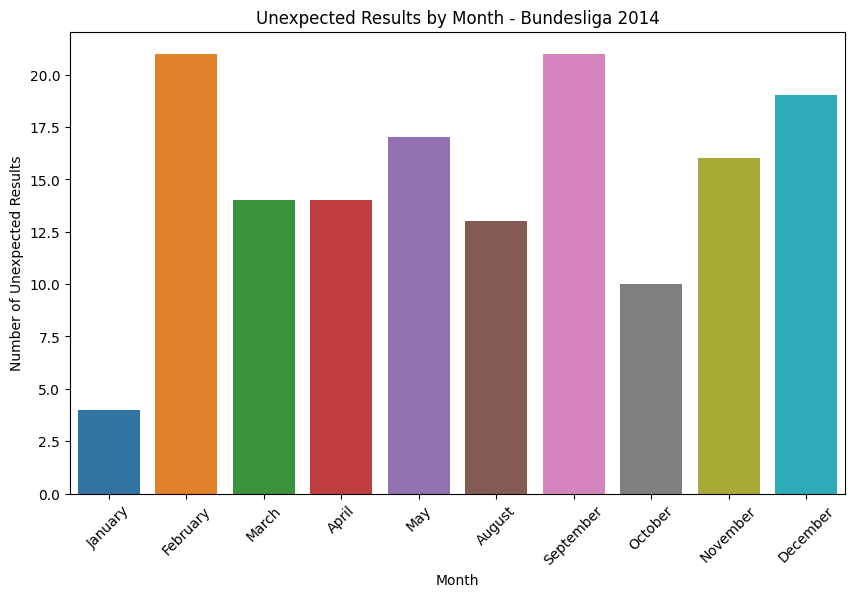

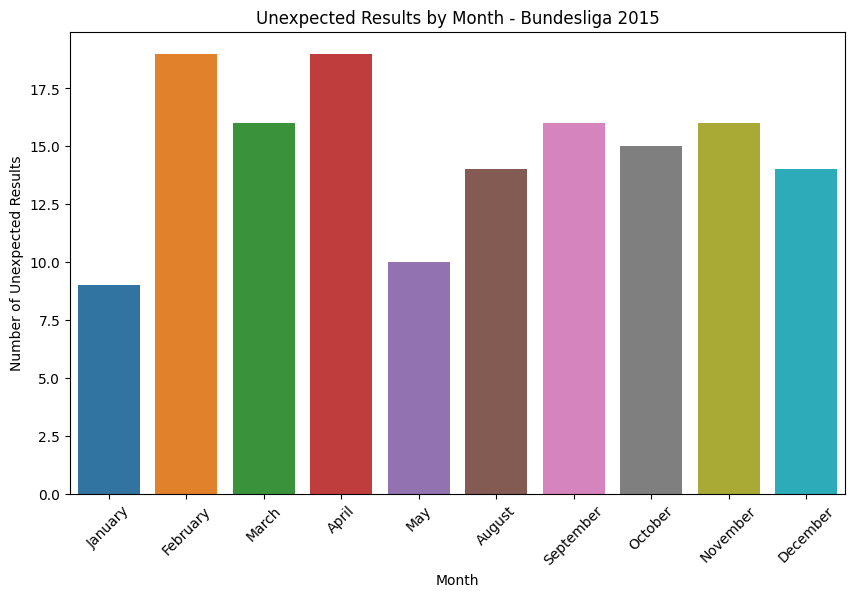

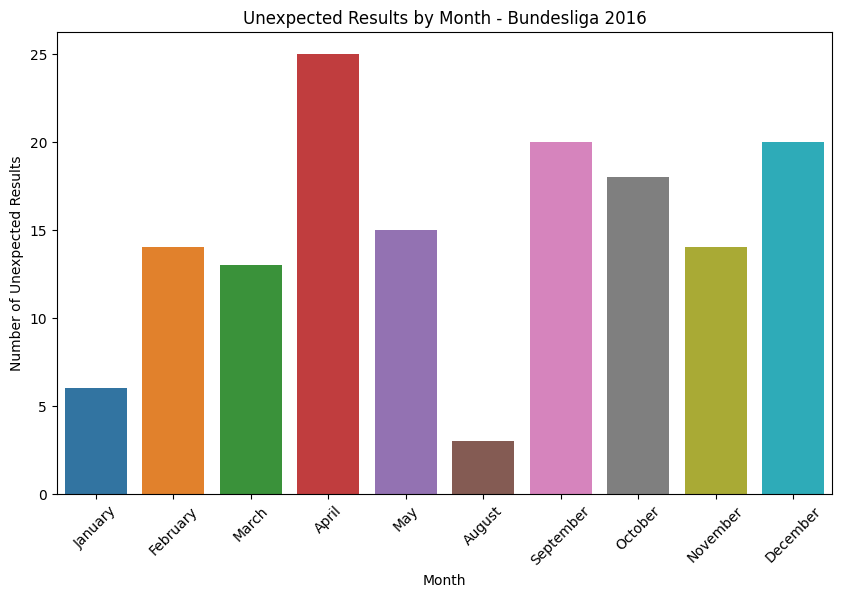

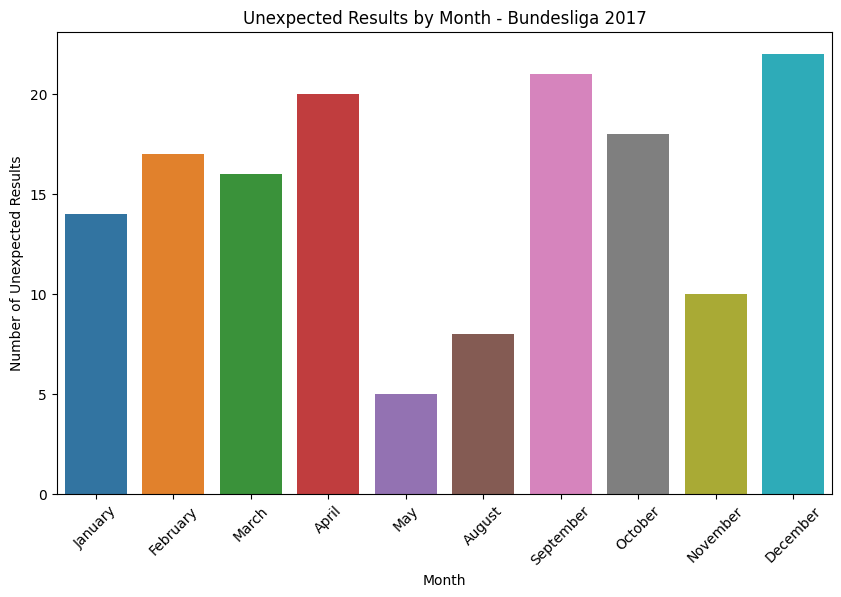

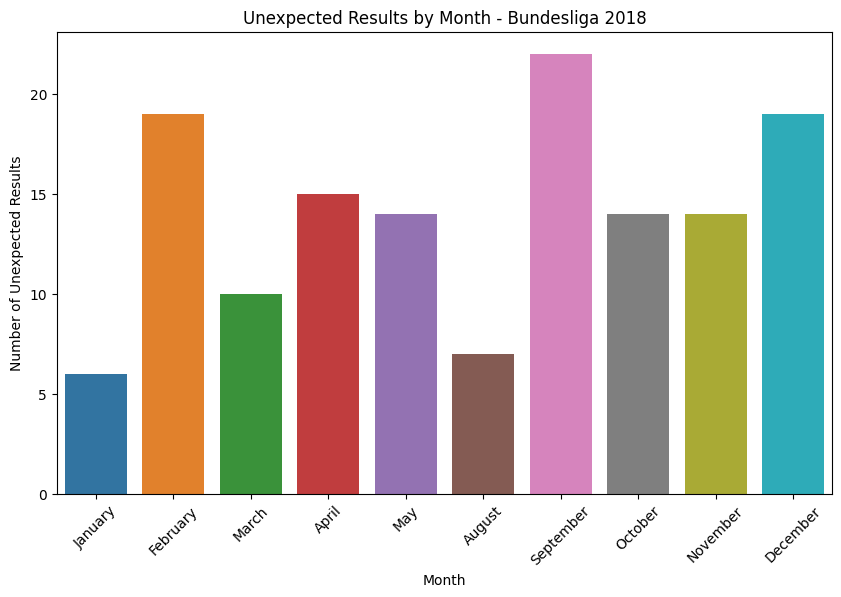

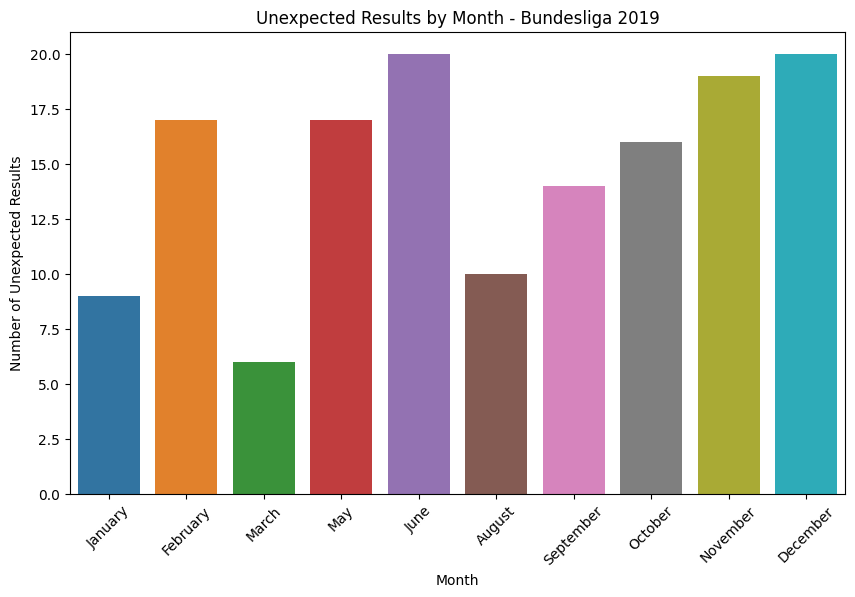

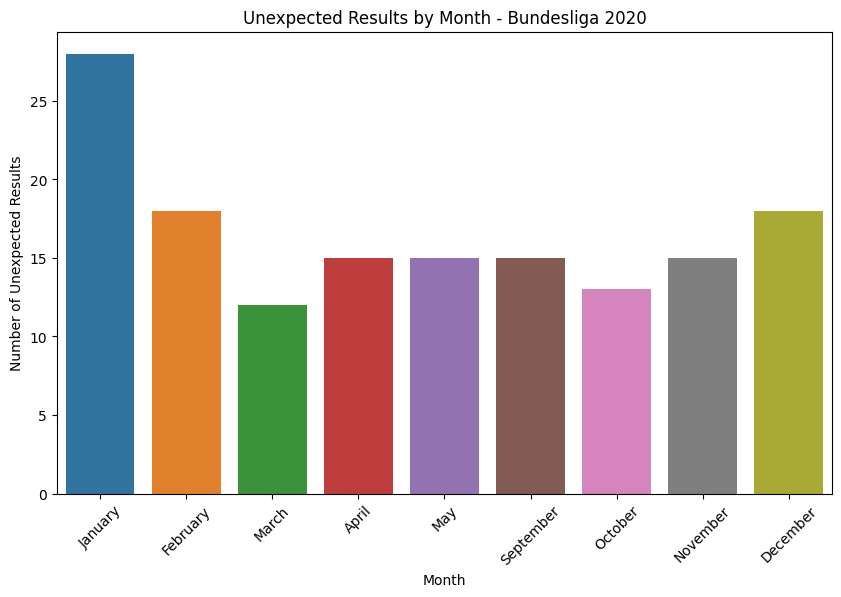

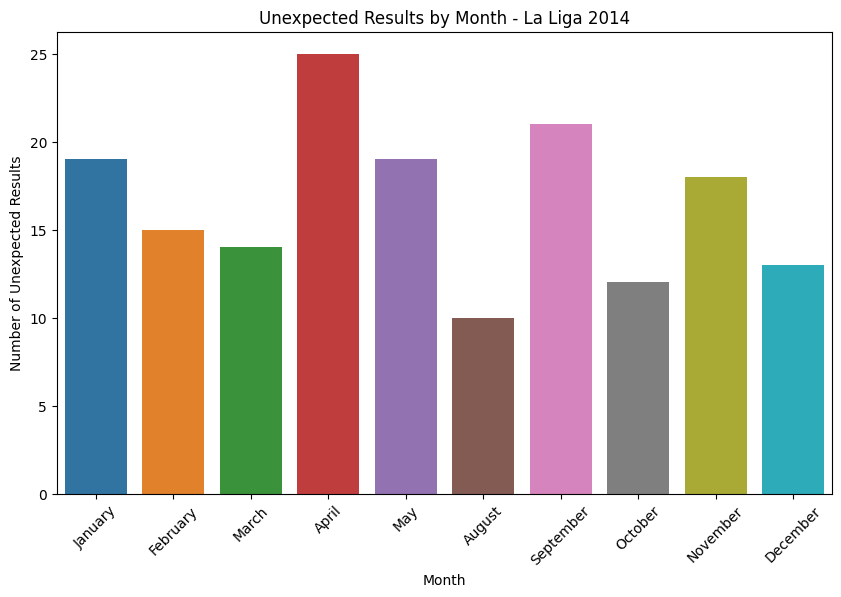

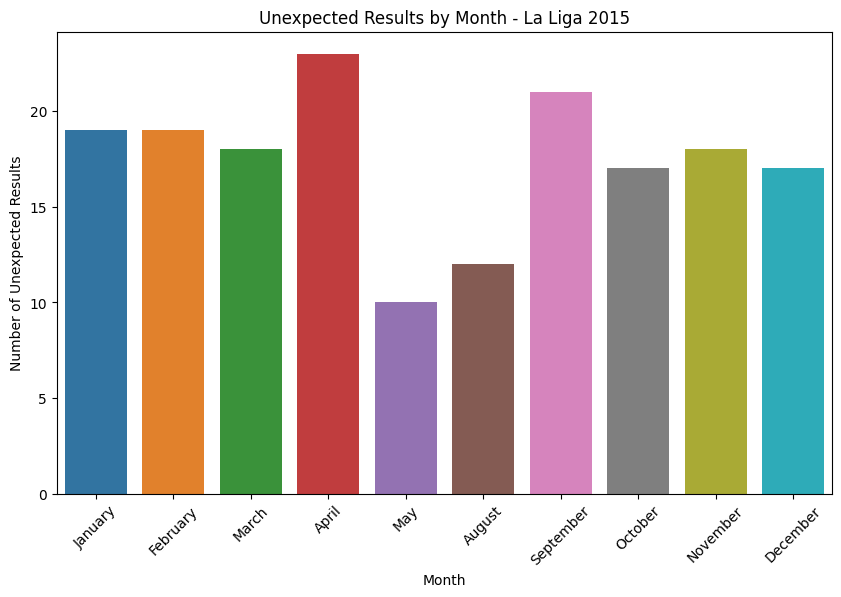

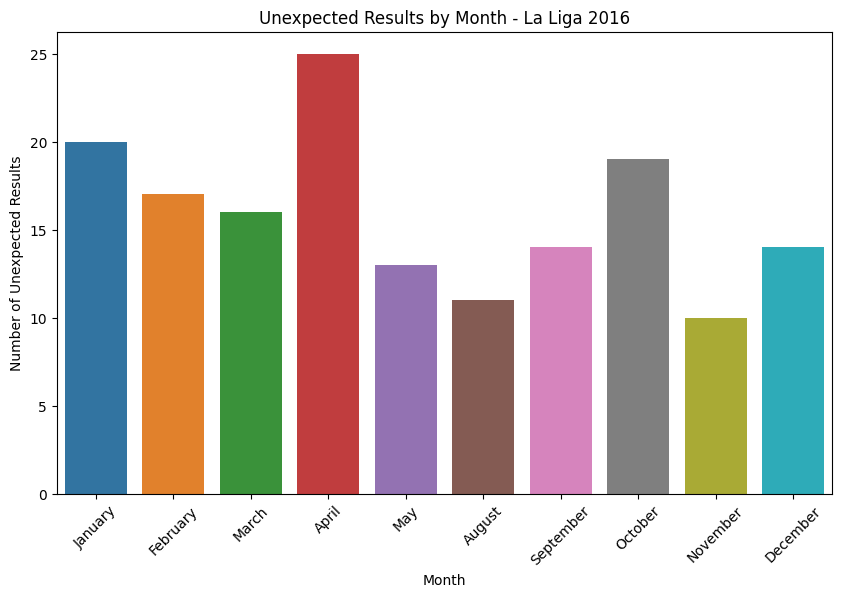

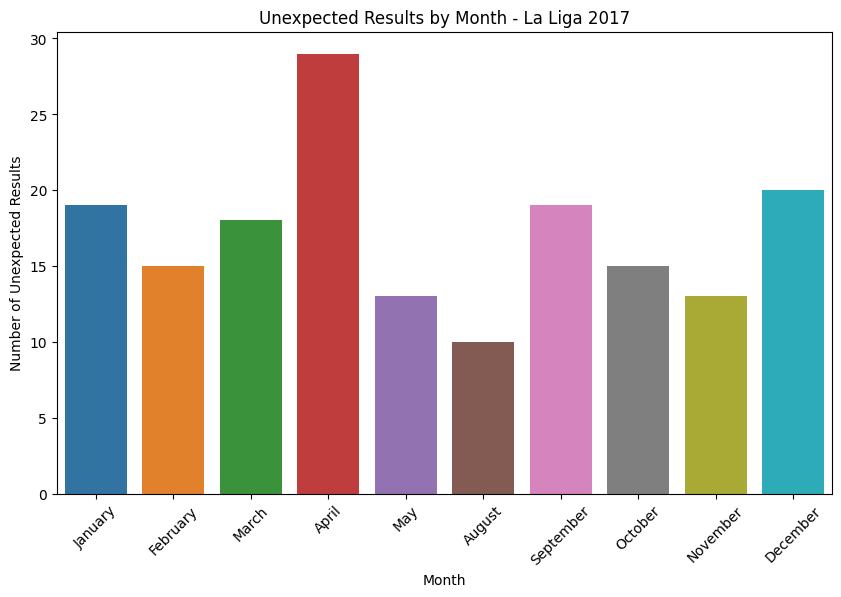

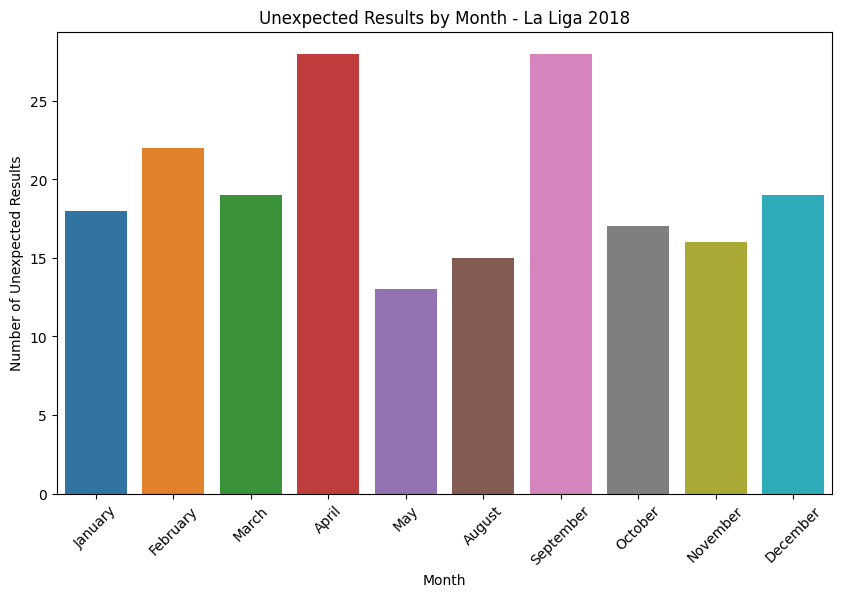

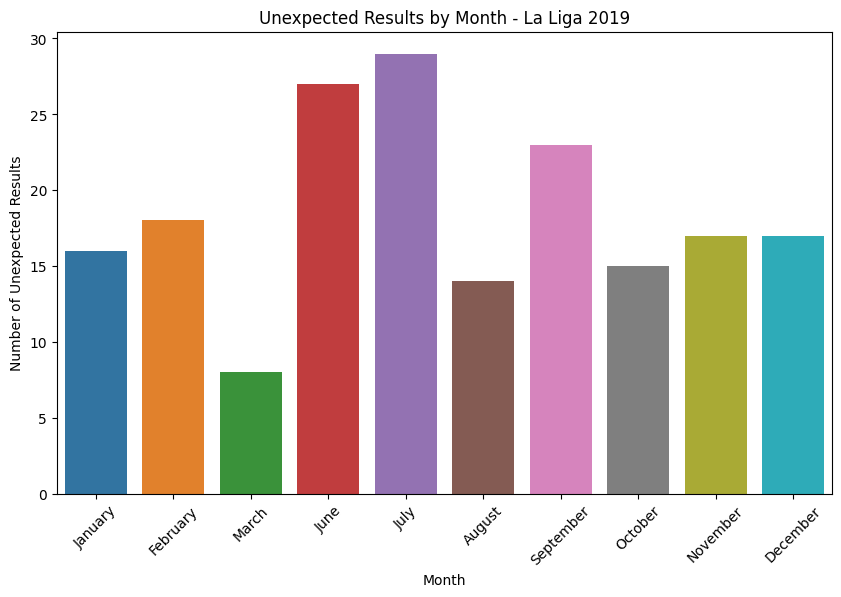

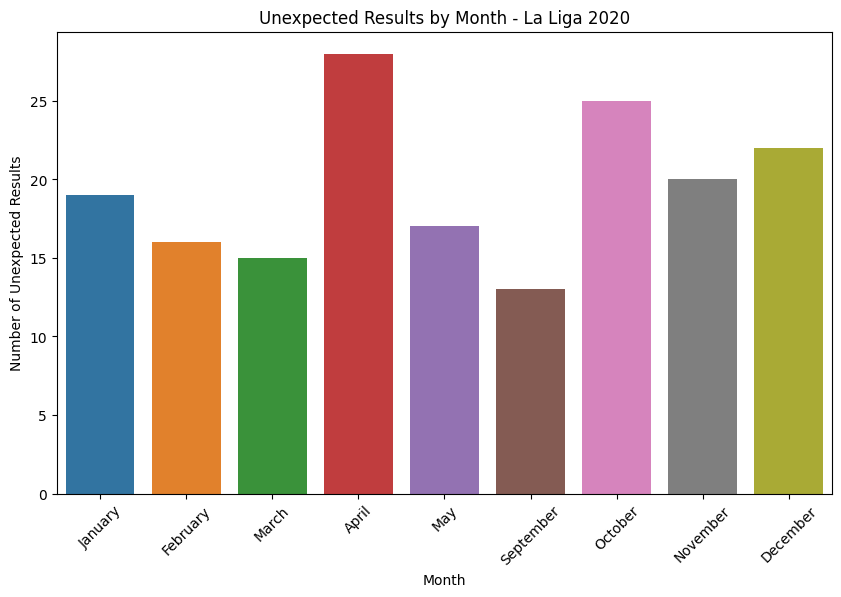

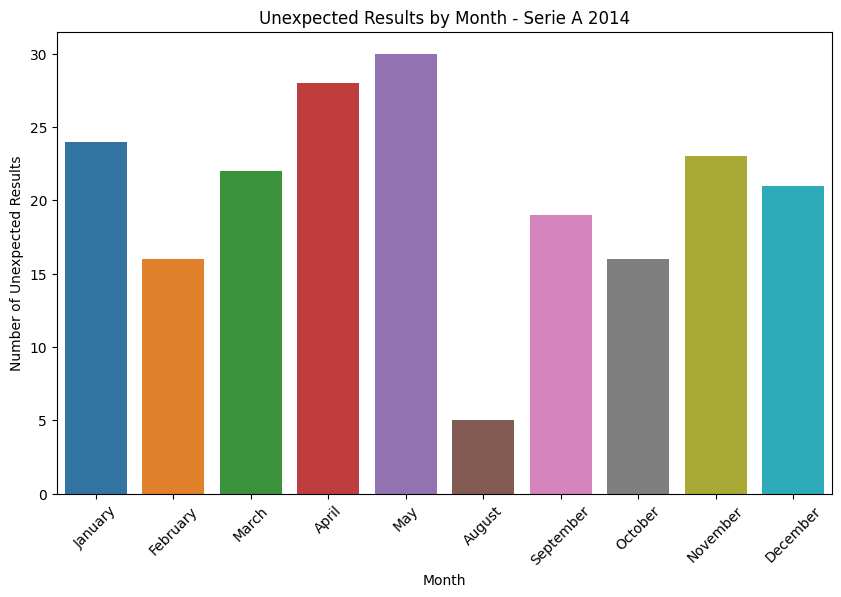

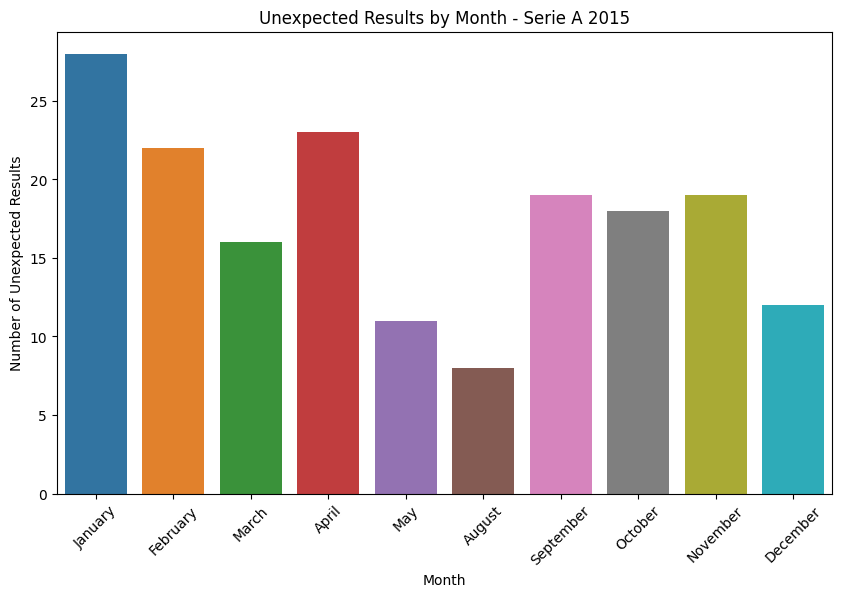

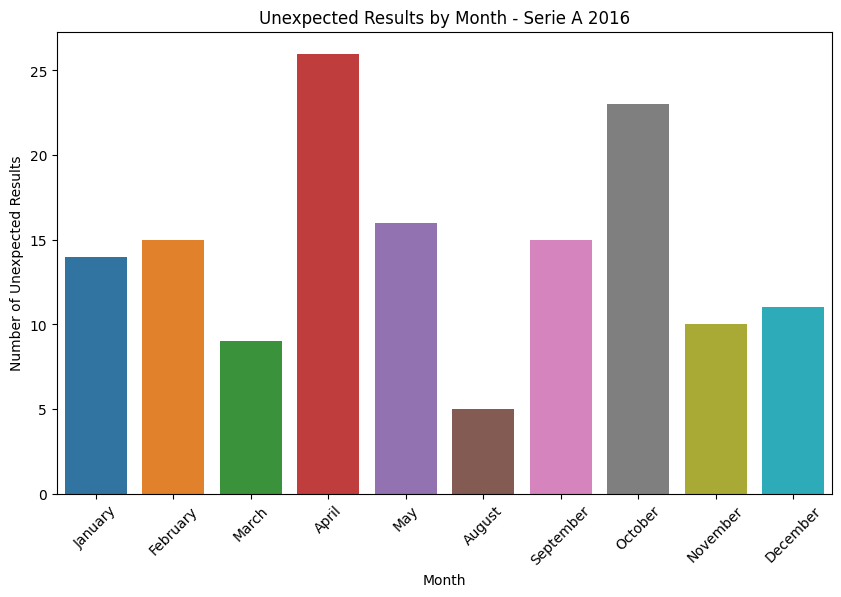

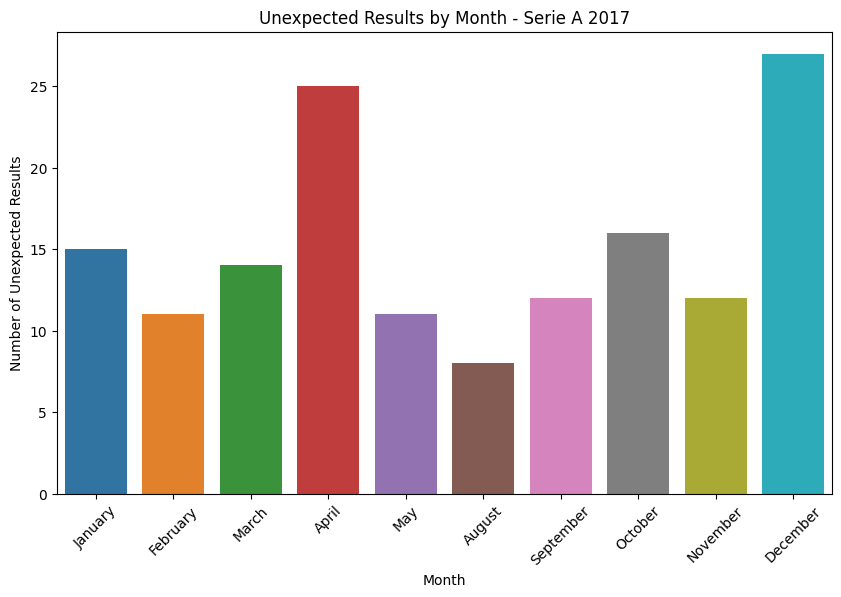

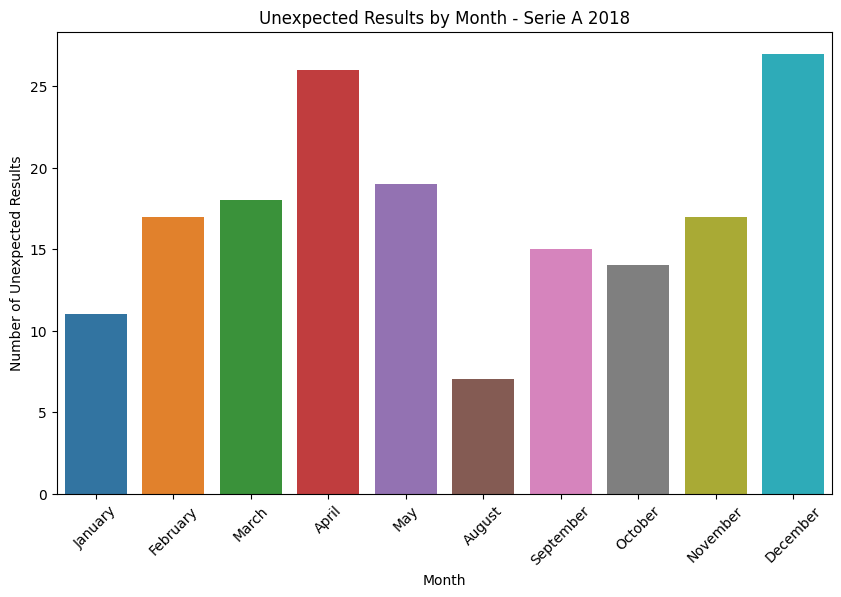

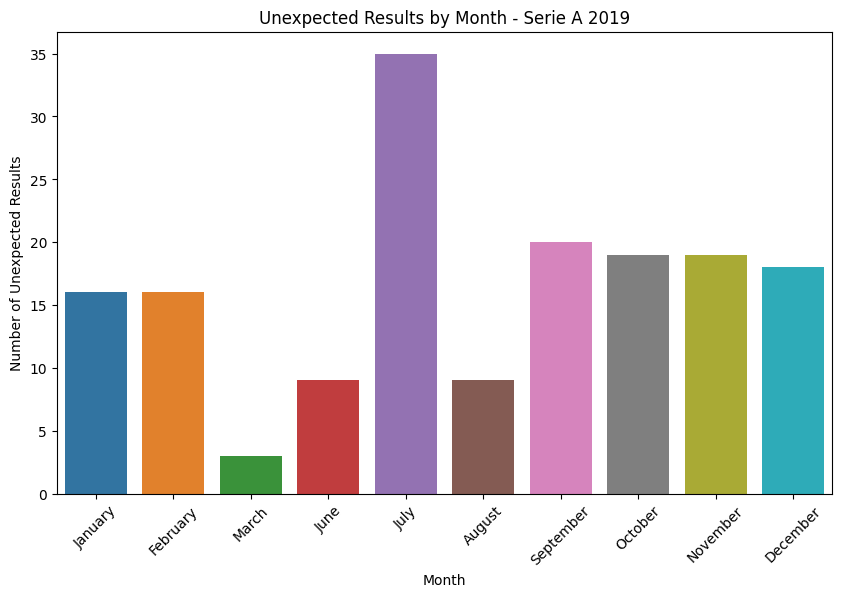

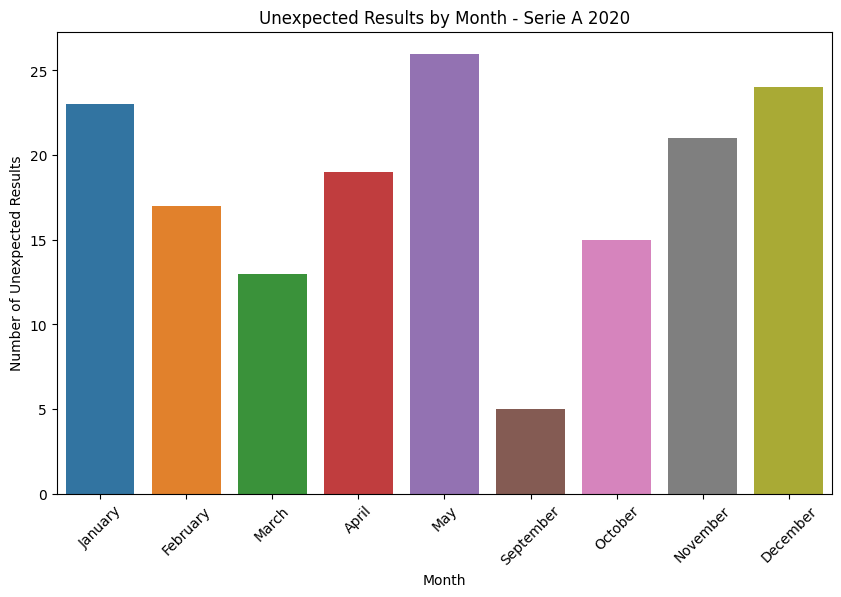

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import calendar

# Set display options to ensure all columns are shown
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)


# Function to determine the actual outcome of a game
def determine_actual_outcome(row):
    if row['homeGoals'] > row['awayGoals']:
        return 'H'  # Home win
    elif row['homeGoals'] < row['awayGoals']:
        return 'A'  # Away win
    else:
        return 'D'  # Draw


# Function to determine the expected outcome based on the lowest bookie coefficient
def determine_expected_outcome(row):
    odds = {
        'H': min(row['B365H'], row['BWH'], row['IWH'], row['PSH'], row['WHH'], row['VCH'], row['PSCH']),
        'D': min(row['B365D'], row['BWD'], row['IWD'], row['PSD'], row['WHD'], row['VCD'], row['PSCD']),
        'A': min(row['B365A'], row['BWA'], row['IWA'], row['PSA'], row['WHA'], row['VCA'], row['PSCA'])
    }
    return min(odds, key=odds.get)  # Return the key with the lowest value


def plot_unexpected_games(unexpected_games_sorted):
    # Assuming you have your dataframe ready as 'unexpected_games_sorted'
    # Group by league and season and count the number of unexpected results
    grouped_data = unexpected_games_sorted.groupby(['leagueName', 'season']).size().reset_index(name='count')

    # Create a bar chart
    plt.figure(figsize=(10, 6))
    sns.barplot(x='season', y='count', hue='leagueName', data=grouped_data)
    plt.title('Unexpected Results by League and Season')
    plt.xlabel('Season')
    plt.ylabel('Number of Unexpected Results')
    plt.xticks(rotation=45)
    plt.legend(title='League')
    plt.tight_layout()
    plt.show()


def plot_monthly_charts(unexpected_games_sorted):
    # Assuming you have your dataframe ready as 'unexpected_games_sorted'
    # Extract month from the date
    unexpected_games_sorted['month'] = pd.to_datetime(unexpected_games_sorted['date']).dt.month
    unexpected_games_sorted['month_name'] = unexpected_games_sorted['month'].apply(lambda x: calendar.month_name[x])


    # Iterate over each combination of league and season
    for league in unexpected_games_sorted['leagueName'].unique():
        for season in unexpected_games_sorted['season'].unique():
            # Filter data for the current league and season
            filtered_data = unexpected_games_sorted[(unexpected_games_sorted['leagueName'] == league) &
                                                    (unexpected_games_sorted['season'] == season)]

            # Group by month name and count the number of unexpected results
            monthly_data = filtered_data.groupby('month_name').size().reset_index(name='count')

            # Sort the data by month (to ensure correct order in the chart)
            monthly_data['month'] = monthly_data['month_name'].apply(lambda x: list(calendar.month_name).index(x))
            monthly_data.sort_values('month', inplace=True)

            # Create a bar chart if there is data for the current league and season
            if not monthly_data.empty:
                plt.figure(figsize=(10, 6))
                sns.barplot(x='month_name', y='count', data=monthly_data)
                plt.title(f'Unexpected Results by Month - {league} {season}')
                plt.xlabel('Month')
                plt.ylabel('Number of Unexpected Results')
                plt.xticks(rotation=45)  # Rotate the month names for better readability
                plt.show()


def print_unexpected():
    # Load the dataset
    games_df = pd.read_csv('sample_data/games.csv')

    team_names_df = pd.read_csv('sample_data/teams.csv')
    league_names_df = pd.read_csv('sample_data/leagues.csv')

    games_df = games_df.merge(team_names_df, left_on='homeTeamID', right_on='teamID', how='left')
    games_df = games_df.rename(columns={'name': 'homeTeamName'}).drop('teamID', axis=1)
    games_df = games_df.merge(team_names_df, left_on='awayTeamID', right_on='teamID', how='left')
    games_df = games_df.rename(columns={'name': 'awayTeamName'}).drop('teamID', axis=1)

    games_df = games_df.merge(league_names_df, left_on='leagueID', right_on='leagueID', how='left')
    games_df = games_df.rename(columns={'name': 'leagueName'}).drop('leagueID', axis=1)

    # Apply functions to determine actual and expected outcomes
    games_df['ActualOutcome'] = games_df.apply(determine_actual_outcome, axis=1)
    games_df['ExpectedOutcome'] = games_df.apply(determine_expected_outcome, axis=1)

    # Identify unexpected games
    unexpected_games = games_df[games_df['ActualOutcome'] != games_df['ExpectedOutcome']]

    # Optionally, sort the unexpected games by date for chronological order
    unexpected_games_sorted = unexpected_games.sort_values(by='date')

    # Display the results
    # print(unexpected_games_sorted.head())  # You can adjust the number of rows to display
    print(unexpected_games_sorted.loc[:,
          ['date', 'leagueName', 'homeTeamName', 'awayTeamName', 'homeGoals', 'awayGoals', 'ActualOutcome',
           'ExpectedOutcome']].head())
    plot_unexpected_games(unexpected_games_sorted)
    plot_monthly_charts(unexpected_games_sorted)


# Press the green button in the gutter to run the script.
if __name__ == '__main__':
    print_unexpected()
